In [ ]:
!pip install lowess

  Created wheel for lowess: filename=lowess-1.0.2-cp36-none-any.whl size=6114 sha256=cfe3e1e68aa1fe2e54686b10f64334f3701077c242e1fa12d6c9bcccf6886b49
  Stored in directory: /root/.cache/pip/wheels/32/45/c2/e70ca4ad60fb118d193cae63ca7a83bb5a443c1eba58e46672
Successfully built lowess


In [ ]:
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy.stats import entropy
from tqdm.notebook import tqdm, trange
import statsmodels.api as sm
from pylab import *
import matplotlib.pyplot as plt
import h5py
import scipy.sparse 
from itertools import groupby
from sklearn import preprocessing
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
import lowess as lo

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
centre = np.load("/content/drive/My Drive/MSc Statistics/centroid_norm.npy", allow_pickle=True)
TS_SS_nonorm = np.load("/content/drive/My Drive/MSc Statistics/TS-SS.npy")
TS_SS_norm = np.load("/content/drive/My Drive/MSc Statistics/TS-SS2.npy")
total_playcount = np.load("/content/drive/My Drive/MSc Statistics/total_playcount.npy")
distinct_songs = np.load("/content/drive/My Drive/MSc Statistics/distinct_songs.npy", allow_pickle=True)
distinct_artists = np.load("/content/drive/My Drive/MSc Statistics/distinct_artists.npy")
pop_score = np.load("/content/drive/My Drive/MSc Statistics/pop_score.npy")
toy_triplets = np.load("/content/drive/My Drive/MSc Statistics/toy_triplets.npy", allow_pickle=True)
toy_triplets = pd.DataFrame(toy_triplets, columns = ["UserId", "SongId", "Count", "TrackId", "Artist", "Song" ])
relative = np.load("/content/drive/My Drive/MSc Statistics/relative.npy")

In [ ]:
pd.DataFrame(TS_SS_norm*10000).describe()

0
count  9.997000e+03
mean   1.150970e+00
std    2.618477e-01
min    1.852093e-07
25%    1.079490e+00
50%    1.253610e+00
75%    1.322196e+00
max    1.457372e+00

In [ ]:
toy_triplets.describe()

UserId  ...           Song
count                                     472358  ...         472358
unique                                     10000  ...          91260
top     dc61155e20289dcd089ac40181cb88f042404602  ...  Sehr kosmisch
freq                                         704  ...           1045

[4 rows x 6 columns]

# Defining main functions

In [ ]:
def plot(p,q, xlab, ylab, filename, frac=0.2):
  # Plots scatterplot with mass gradient and LOwESS
  # p - x variable
  # q - y variable

  # stacking data for the density gradient
  xy = np.vstack([p,q])
  # calling 
  z = gaussian_kde(xy)(xy)

  idx = z.argsort()
  x, y, z = p[idx], q[idx], z[idx]

  df = pd.DataFrame({'x': x, 'Raw': y})
  df["pred"] = lo.lowess(df["Raw"], df["x"], frac, 2)

  # sorting so that could plot a somehow monotonic line
  sorted_index = np.argsort(df["Raw"])
  X_sort = df["Raw"][sorted_index]
  y_sort = df["pred"][sorted_index]  

  fig, ax = plt.subplots()
  # main scatter
  ax.scatter(df["Raw"], df["x"], c=z, s=50, edgecolor='', cmap=plt.cm.summer)
  # LOWESS 
  ax.plot(X_sort, y_sort, "r", label="LOWESS")
  leg = ax.legend(loc=7)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(filename, format = "png", transparent = True)
  plt.show()

# Loading data and preprocessing

In [ ]:
# embedded vectors data
embeds = np.load("/content/drive/My Drive/MSc Statistics/track-embeddings-v2.npz", allow_pickle=True)

In [ ]:
#shape of the song vectors
print(embeds["beta"].shape)
# shape of the link vector
print(embeds["mapping"].shape)

(384546, 100)
(384546,)


In [ ]:
# these link vectors correspond to SongId
embeds["mapping"][1]

'SOAPDEY12A81C210A9'

In [ ]:
embeds["beta"][1]

array([3.3387587e-05, 5.3167518e-05, 3.7511396e-05, 3.1623826e-05,
       3.8105747e-05, 4.0210991e-05, 3.7024838e-05, 2.8700993e-04,
       4.5484743e-05, 3.7686768e-05, 3.5270859e-05, 3.8034086e-05,
       3.2809596e-05, 3.4930254e-05, 3.8884675e-05, 3.9249993e-05,
       4.0555289e-05, 3.9312585e-05, 3.0627172e-04, 3.9259048e-05,
       3.2740070e-05, 3.6596230e-05, 3.4108638e-05, 3.7176476e-05,
       3.7189002e-05, 3.5354009e-05, 3.7822832e-05, 3.5257755e-05,
       3.7416590e-05, 3.8893424e-05, 3.3348300e-05, 3.4948628e-02,
       3.3000120e-05, 3.5846882e-05, 3.2762822e-05, 3.1593092e-05,
       3.6990761e-05, 3.7074573e-05, 3.8720995e-05, 1.8778513e-01,
       3.3923563e-05, 3.2184933e-05, 3.7071823e-05, 3.3005912e-05,
       3.4150580e-05, 3.3585435e-05, 4.1402422e-05, 3.8520087e-05,
       2.3419659e-03, 1.6008746e-03, 3.9353290e-05, 3.7198577e-05,
       3.6987520e-05, 3.7360980e-05, 3.7270333e-05, 3.5709934e-05,
       4.3503303e-05, 7.0825314e-05, 4.3346019e-05, 3.7585218e

In [ ]:
# normalizing the vectors to have a unit norm as in the paper
emb_norm = preprocessing.normalize(embeds["beta"], norm='l2')

In [1]:
# moving to pandas to exploit indexing for computational speed
pan_emb = pd.DataFrame(emb_norm)

NameError: name 'pd' is not defined

In [ ]:
# Sanity check
np.linalg.norm(emb_norm[1000])

1.0

In [ ]:
pan_emb_nonorm = pd.DataFrame(embeds["beta"])

# Creating the same subsample as with entropies


In [ ]:
# check which songs are remaining and leaving only those
songs = toy_triplets["SongId"].unique().tolist()
songs_pd = pd.DataFrame(songs, columns=["SongId"])
embeds_songs = pd.DataFrame(embeds["mapping"], columns=["SongId"])
embeds_songs["Location"] = embeds_songs.index

embeds_songs = pd.merge(left = embeds_songs, right = songs_pd, left_on="SongId", right_on="SongId")

In [ ]:
embeds_songs

SongId  Location
0       SOAKIMP12A8C130995         0
1       SOAPDEY12A81C210A9         1
2       SOBBMDR12A8C13253B         2
3       SOBFNSP12AF72A0E22         3
4       SOBFOVM12A58A7D494         4
...                    ...       ...
105291  SOAYITK12AB018E165    383856
105292  SORGUGD12A8AE46BD6    383909
105293  SOQLZES12A58A776D4    383973
105294  SOUBFHW12AB0182855    384157
105295  SOKXWQB12AB017F214    384422

[105296 rows x 2 columns]

# Generalist-Specialist score


Computing Generalist-Specialist score. It is the square norm of the centroid vector. The implementation from scratch is also conducted to show equivallence numerically. Mathematicl proof is in the paper.

In [ ]:
# first try to get centroid
def centroid(p,w):
  # assume we have a joint np array.
  # Joint means all song vectors are stacked vertically
  # w gotta be a n_i x 1 np array
  weighted = p * w
  joint = weighted.sum(axis=0)
  return joint/np.sum(w)

In [ ]:
users = toy_triplets["UserId"].unique().tolist()

In [ ]:
centre = []
for i in tqdm(users):
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp]
  # function centroid requires weight vector to be a column vector
  weights = songs_loop["Count"].to_numpy().reshape(-1,1)
  # appending function values
  centre.append(centroid(extract_vec.to_numpy(), weights))

In [ ]:
np.save("centroid_norm", centre)

In [ ]:
# Squared norm of the centroid is the GS score
GS = []
for x in centre:
  GS.append(np.linalg.norm(x))

In [ ]:
# GS score from the scratch
GS_full = []
for i, x in tqdm(zip(users, centre)):
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp]
  # function centroid requires weight vector to be a column vector
  weights = songs_loop["Count"].to_numpy()

  a = []
  for j, w in zip(extract_vec.to_numpy(), weights):
    b = w * np.reshape(j, (1, -1))
    c = np.reshape(x, (-1, 1))
    songs_centre =  np.dot( b, c )/np.linalg.norm(x)
    a.append(songs_centre)
  joint = np.sum(a)/np.sum(weights)
  GS_full.append(joint)

In [ ]:
# checking if there is a problem of overlapping songs
uni = []
for i, x in tqdm(zip(users, centre)):
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp]

  a = []
  # calculating a pure cosine similarity between each song and a centroid
  for j in extract_vec.to_numpy():
    b =  np.reshape(j, (1, -1))
    c = np.reshape(x, (-1, 1))
    songs_centre =  np.dot( b, c )/np.linalg.norm(c)
    # checking a proportion of unique angles
    a.append(songs_centre)
  uni.append(len(np.unique(a))/len(a))

In [ ]:
np.save("Alligned_vectors", uni)

In [ ]:
pd.DataFrame(uni).describe()

0
count  10000.000000
mean       0.999832
std        0.003347
min        0.812500
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

In [ ]:
len(np.array(uni)[np.array(uni)<1])

66

In [ ]:
np.where(np.array(uni)<1)

(array([ 120,  223,  466,  491,  701,  724,  771, 1252, 1417, 1451, 1964,
        2218, 2290, 2386, 2427, 2505, 2877, 3037, 3127, 3151, 3201, 3592,
        3686, 3758, 4137, 4351, 4433, 4587, 4749, 5101, 5291, 5321, 5582,
        5655, 5709, 6088, 6189, 6334, 6376, 6442, 6465, 6576, 6589, 6635,
        6977, 7029, 7458, 7496, 7827, 7892, 8132, 8137, 8211, 8629, 8645,
        8677, 8747, 8827, 9173, 9190, 9230, 9495, 9596, 9654, 9898, 9930]),)

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[120]].describe()

UserId  ...        Song
count                                        416  ...         416
unique                                         1  ...         415
top     95c7ed3c6c726617827745303d136d1898dea29f  ...  Just Dance
freq                                         416  ...           2

[4 rows x 6 columns]

In [ ]:
songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==users[120]]
# merging with the location as found in the embeds["mapping"]
loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
extract_vec = pan_emb.iloc[loc_temp]

a = []
# calculating a pure cosine similarity between each song and a centroid
for j in extract_vec.to_numpy():
  b =  np.reshape(j, (1, -1))
  c = np.reshape(centre[120], (-1, 1))
  songs_centre =  np.dot( b, c )/np.linalg.norm(c)
    # checking a proportion of unique angles
  a.append(songs_centre)

In [ ]:
unique, counts = np.unique(a, return_counts=True)

In [ ]:
np.where(counts>1)

(array([406]),)

In [ ]:
np.where(a==unique[406])

(array([403, 412]), array([0, 0]), array([0, 0]))

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[120]].iloc[403]

UserId     95c7ed3c6c726617827745303d136d1898dea29f
SongId                           SOMRZGY12A81C231B9
Count                                             1
TrackId                          TRKKRMX12903CC546A
Artist                                   Dismantled
Song          Thanks For Everything (Album Version)
Name: 5726, dtype: object

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[120]].iloc[412]

UserId     95c7ed3c6c726617827745303d136d1898dea29f
SongId                           SOYCNLA12A81C231AB
Count                                             1
TrackId                          TRNYWKO12903CC545D
Artist                                   Dismantled
Song                                         Fields
Name: 5735, dtype: object

In [ ]:
songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==users[223]]
# merging with the location as found in the embeds["mapping"]
loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
extract_vec = pan_emb.iloc[loc_temp]

a = []
# calculating a pure cosine similarity between each song and a centroid
for j in extract_vec.to_numpy():
  b =  np.reshape(j, (1, -1))
  c = np.reshape(centre[120], (-1, 1))
  songs_centre =  np.dot( b, c )/np.linalg.norm(c)
    # checking a proportion of unique angles
  a.append(songs_centre)

In [ ]:
unique, counts = np.unique(a, return_counts=True)
np.where(counts>1)

(array([104]),)

In [ ]:
np.where(a==unique[104])

(array([103, 105]), array([0, 0]), array([0, 0]))

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[223]].iloc[103]

UserId     9dab66be02fa349a6f95faed38c9849108cc3f9f
SongId                           SOEPPAU12A5891DC11
Count                                             1
TrackId                          TRRPMNM128F92FFB42
Artist                                 Big Boss Man
Song                                  Trilby of Fun
Name: 10509, dtype: object

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[223]].iloc[105]

UserId     9dab66be02fa349a6f95faed38c9849108cc3f9f
SongId                           SOVTBTH12A58A80DEC
Count                                             1
TrackId                          TRHTITZ128F92FFB3D
Artist                                 Big Boss Man
Song                                        VIP 233
Name: 10511, dtype: object

In [ ]:
embeds["beta"][embeds["mapping"]=="SOMRZGY12A81C231B9"]

array([[3.1044608e-05, 5.0703140e-05, 3.5562767e-05, 3.0817864e-05,
        3.5360972e-05, 3.9199022e-05, 3.5015586e-05, 3.5207369e-05,
        4.1223710e-05, 3.4908066e-05, 3.3492655e-05, 3.5473291e-05,
        3.1312225e-05, 3.2094595e-05, 3.7454065e-05, 3.5208632e-05,
        3.8867587e-05, 3.6286692e-05, 3.1584190e-05, 3.6231657e-05,
        3.1401771e-05, 3.4491099e-05, 3.1144184e-05, 3.0230533e-05,
        3.5283450e-05, 3.2862721e-05, 3.5541445e-05, 3.3379776e-05,
        3.5650508e-05, 3.4634719e-05, 3.0079094e-05, 3.8881990e-05,
        3.0937528e-05, 3.3385884e-05, 3.1420015e-05, 3.0065170e-05,
        3.5316702e-05, 3.6719674e-05, 3.4890738e-05, 3.3456356e-05,
        3.0997871e-05, 3.0982996e-05, 3.6152058e-05, 3.1428634e-05,
        3.1929161e-05, 3.1006526e-05, 1.3841217e-04, 3.5230063e-05,
        3.1057840e-05, 3.5337114e-05, 3.5331570e-05, 3.4818084e-05,
        3.4531335e-05, 3.5172427e-05, 3.6098168e-05, 3.1105064e-05,
        3.5707289e-05, 6.8434550e-05, 3.9949009e

In [ ]:
embeds["beta"][embeds["mapping"]=="SOYCNLA12A81C231AB"]

array([[3.1044608e-05, 5.0703140e-05, 3.5562767e-05, 3.0817864e-05,
        3.5360972e-05, 3.9199022e-05, 3.5015586e-05, 3.5207369e-05,
        4.1223710e-05, 3.4908066e-05, 3.3492655e-05, 3.5473291e-05,
        3.1312225e-05, 3.2094595e-05, 3.7454065e-05, 3.5208632e-05,
        3.8867587e-05, 3.6286692e-05, 3.1584190e-05, 3.6231657e-05,
        3.1401771e-05, 3.4491099e-05, 3.1144184e-05, 3.0230533e-05,
        3.5283450e-05, 3.2862721e-05, 3.5541445e-05, 3.3379776e-05,
        3.5650508e-05, 3.4634719e-05, 3.0079094e-05, 3.8881990e-05,
        3.0937528e-05, 3.3385884e-05, 3.1420015e-05, 3.0065170e-05,
        3.5316702e-05, 3.6719674e-05, 3.4890738e-05, 3.3456356e-05,
        3.0997871e-05, 3.0982996e-05, 3.6152058e-05, 3.1428634e-05,
        3.1929161e-05, 3.1006526e-05, 1.3841217e-04, 3.5230063e-05,
        3.1057840e-05, 3.5337114e-05, 3.5331570e-05, 3.4818084e-05,
        3.4531335e-05, 3.5172427e-05, 3.6098168e-05, 3.1105064e-05,
        3.5707289e-05, 6.8434550e-05, 3.9949009e

These are equivalent!!!


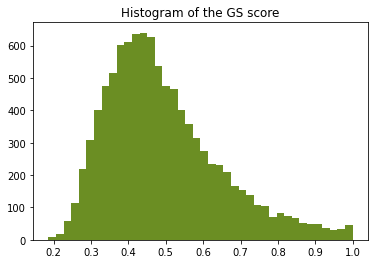

In [ ]:
plt.hist(GS, bins = 40,
                 color = "olivedrab", density = False)
plt.title("Histogram of the GS score")
plt.savefig("GS_hist", format = "png", transparent = True)

In [ ]:
pd.DataFrame(GS).describe()

0
count  10000.000000
mean       0.492246
std        0.152524
min        0.185658
25%        0.381673
50%        0.462323
75%        0.573857
max        1.000000

In [ ]:
a = [len(np.unique(GS))/len(GS)]
a

[1.0]

# TS-SS


In [ ]:
import math
import numpy as np

class TS_SS:
    
    def Cosine(self, vec1: np.ndarray, vec2: np.ndarray):
        return np.dot(vec1, vec2.T)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))

    def VectorSize(self, vec: np.ndarray):
        return np.linalg.norm(vec)

    def Euclidean(self, vec1: np.ndarray, vec2: np.ndarray):
        return np.linalg.norm(vec1-vec2)

    def Theta(self, vec1: np.ndarray, vec2: np.ndarray):
        return np.arccos(self.Cosine(vec1, vec2)) + np.radians(10)

    def Triangle(self, vec1: np.ndarray, vec2: np.ndarray):
        theta = np.radians(self.Theta(vec1, vec2))
        return (self.VectorSize(vec1) * self.VectorSize(vec2) * np.sin(theta))/2

    def Magnitude_Difference(self, vec1: np.ndarray, vec2: np.ndarray):
        return abs(self.VectorSize(vec1) - self.VectorSize(vec2))

    def Sector(self, vec1: np.ndarray, vec2: np.ndarray):
        ED = self.Euclidean(vec1, vec2)
        MD = self.Magnitude_Difference(vec1, vec2)
        theta = self.Theta(vec1, vec2)
        return math.pi * (ED + MD)**2 * theta/360


    def __call__(self, vec1: np.ndarray, vec2: np.ndarray):
        return self.Triangle(vec1, vec2) * self.Sector(vec1, vec2)


In [ ]:
centre_nonorm = []
for i in tqdm(users):
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb_nonorm.iloc[loc_temp]
  # function centroid requires weight vector to be a column vector
  weights = songs_loop["Count"].to_numpy().reshape(-1,1)
  # appending function values
  centre_nonorm.append(centroid(extract_vec.to_numpy(), weights))

In [ ]:
np.save("centroids_nonorm", centre_nonorm)

In [ ]:
centre_nonorm = np.load("/content/drive/My Drive/MSc Statistics/centroids_nonorm.npy")

In [ ]:
# TSSS score implementation
TSSS2 = []
for i, x in tqdm(zip(users, centre)):
  # data management
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb_nonorm.iloc[loc_temp]
  # function centroid requires weight vector to be a column vector
  weights = songs_loop["Count"].to_numpy()

# TS-SS starts here
  a = []
  for j, w in zip(extract_vec.to_numpy(), weights):
    #call a class
    tsss = TS_SS()
    a.append(w *tsss(j,x))
  joint = np.sum(a)/np.sum(weights)
  TSSS2.append(joint)

In [ ]:
# TSSS score implementation - normalized data
TSSS2 = []
for i, x in tqdm(zip(users, centre)):
  # data management
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp]
  # function centroid requires weight vector to be a column vector
  weights = songs_loop["Count"].to_numpy()

# TS-SS starts here
  a = []
  for j, w in zip(extract_vec.to_numpy(), weights):
    #call a class
    tsss = TS_SS()
    a.append(w *tsss(j,x))
  joint = np.sum(a)/np.sum(weights)
  TSSS2.append(joint)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


In [ ]:
np.save("TS-SS2", TSSS2)

In [ ]:
len(np.unique(TS_SS_norm))/len(TS_SS_norm)

1.0

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


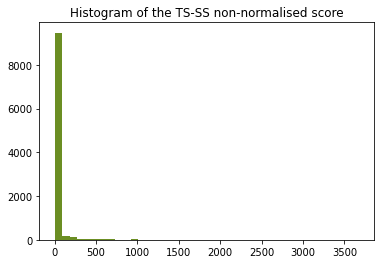

In [ ]:
plt.hist(TS_SS_nonorm, bins = 40,
                          color = "olivedrab", density = False)
plt.title("Histogram of the TS-SS non-normalised score")
plt.savefig("TSSS_nonorm_hist", format = "png", transparent = True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


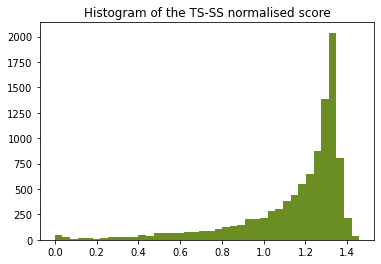

In [ ]:
plt.hist(TS_SS_norm*10000, bins = 40,
                          color = "olivedrab", density = False)
plt.title("Histogram of the TS-SS normalised score")
plt.savefig("TSSS_norm_hist", format = "png", transparent = True)

In [ ]:
TS_SS_norm*10000

array([0.73531229, 1.17960249, 1.29978716, ..., 1.22758338, 1.27074258,
       1.3632586 ])

In [ ]:
pd.DataFrame(TS_SS_nonorm).describe()

0
count  9.997000e+03
mean   2.780081e+01
std    1.550038e+02
min    1.760873e-15
25%    2.266076e-04
50%    1.234074e-02
75%    1.059745e+00
max    3.675942e+03

In [ ]:
np.where(pop_score>200)

(array([3803]),)

In [ ]:
pd.DataFrame(pop_score).describe()

0
count  10000.000000
mean       7.249800
std       11.927516
min        0.000000
25%        1.000000
50%        4.000000
75%        9.000000
max      224.000000

In [ ]:
distinct_songs[3803]

array(['e0f23f18d24717459cc0a676855b1b0c26b7f9dc', 246], dtype=object)

In [ ]:
TS_SS_nonorm[3803]

74.19365419145608

In [ ]:
np.where(TS_SS_nonorm>2500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(array([5501, 5703, 6728, 9283, 9294, 9555]),)

In [ ]:
TS_SS_norm[5703]*10000

0.7404166533158617

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[3803]]

UserId  ...                                   Song
177880  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...                           Learn To Fly
177881  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...                          Sehr kosmisch
177882  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...       Behind The Sea [Live In Chicago]
177883  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...                                  Drive
177884  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...       Jamaica Roots II(Agora E Sempre)
...                                          ...  ...                                    ...
178121  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...                         Blue Christmas
178122  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...  Burn It To The Ground (Album Version)
178123  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...                             Girl Money
178124  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...                     The Christmas Song
178125  e0f23f18d24717459cc0a676855b1b0c26b7f9dc  ...              Things I Don't Understand

[246 rows x 6 columns]

In [ ]:
# checking if there is a problem of overlapping songs
uni_tsss = []
for i, x in tqdm(zip(users, centre_nonorm)):
  # data management
  songs_loop = toy_triplets[["SongId", "Count"]][toy_triplets["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb_nonorm.iloc[loc_temp]

  a = []
  tsss = TS_SS()
  # calculating a pure cosine similarity between each song and a centroid
  for j in extract_vec.to_numpy():
    a.append(tsss(j,x))
  uni_tsss.append(len(np.unique(a))/len(a))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arccos


In [ ]:
np.save("TSSS-flaw", uni_tsss)

In [ ]:
len(np.array(uni_tsss)[np.array(uni_tsss)<1])

66

In [ ]:
np.where(np.array(uni_tsss)<1)

(array([ 120,  223,  466,  491,  701,  724,  771, 1252, 1417, 1451, 1964,
        2218, 2290, 2386, 2427, 2505, 2877, 3037, 3127, 3151, 3201, 3592,
        3686, 3758, 4137, 4351, 4433, 4587, 4749, 5101, 5291, 5321, 5582,
        5655, 5709, 6088, 6189, 6334, 6376, 6442, 6465, 6576, 6589, 6635,
        6977, 7029, 7458, 7496, 7827, 7892, 8132, 8137, 8211, 8629, 8645,
        8677, 8747, 8827, 9173, 9190, 9230, 9495, 9596, 9654, 9898, 9930]),)

# Ommit nan's

In [ ]:
distinct_songs[:,1]

array([11, 11, 14, ..., 15, 12, 47], dtype=object)

In [ ]:
index = np.argwhere(np.isnan(TS_SS_nonorm))
TS_SS_nonorm2 = np.delete(TS_SS_nonorm, index)
print(index)

[[ 604]
 [8972]
 [9221]]


In [ ]:
index = np.argwhere(np.isnan(TS_SS_norm))
TS_SS_norm2 = np.delete(TS_SS_norm, index)
print(index)

[[ 604]
 [8972]
 [9221]]


In [ ]:
total_playcount2 = np.delete(total_playcount, index)
distinct_songs2 = np.delete(distinct_songs[:,1], index)
distinct_artists2 = np.delete(distinct_artists, index)
pop_score2 = np.delete(pop_score, index)
users2 = np.delete(users, index)

# Total User Activity



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


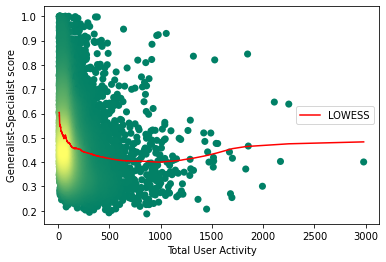

In [ ]:
plot(np.array(GS), total_playcount, "Total User Activity", "Generalist-Specialist score", "GS_playcount", frac = 0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


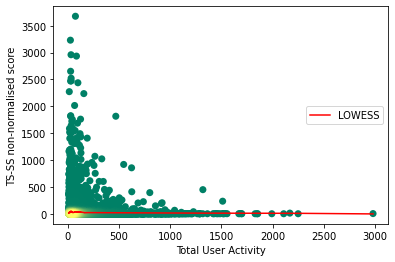

In [ ]:
plot(TS_SS_nonorm2, total_playcount2, "Total User Activity", "TS-SS non-normalised score", "TS-SS-R_playcount", frac = 0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


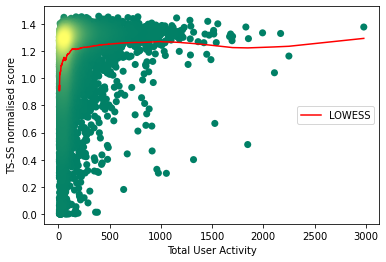

In [ ]:
plot(TS_SS_norm2 * 10000, total_playcount2, "Total User Activity", "TS-SS normalised score", "TS-SS-N_playcount", frac = 0.2)

# Distinct Songs

In [ ]:
plot(np.array(GS), distinct_songs[:,1].astype("float"), "Distinct songs", "Generalist-Specialist score", "GS_songs", frac = 0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


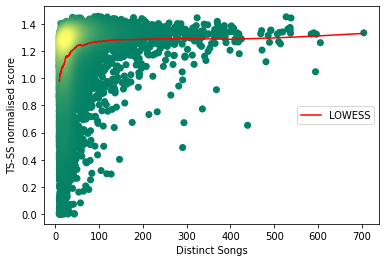

In [ ]:
plot(TS_SS_norm2 * 10000, distinct_songs2.astype("float"), "Distinct Songs", "TS-SS normalised score", "TS_SS_songs", frac = 0.2)

# Distinct Artists

In [ ]:
plot(np.array(GS), distinct_artists, "Distinct artists", "Generalist-Specialist score", "GS_art", frac = 0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


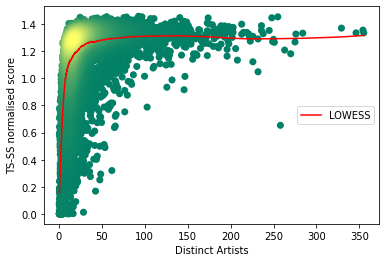

In [ ]:
plot(TS_SS_norm2*10000, distinct_artists2, "Distinct Artists", "TS-SS normalised score", "TS-SS-artists", frac = 0.2)

# Popularity

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


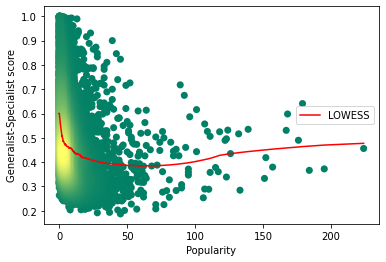

In [ ]:
plot(np.array(GS), pop_score, "Popularity", "Generalist-Specialist score", "GS_pop", frac = 0.3)

In [ ]:
np.divide(pop_score2, distinct_songs2.astype("float"))

array([0.        , 0.36363636, 0.07142857, ..., 0.13333333, 0.08333333,
       0.63829787])

In [ ]:
distinct_songs2.astype("float")

array([11., 11., 14., ..., 15., 12., 47.])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


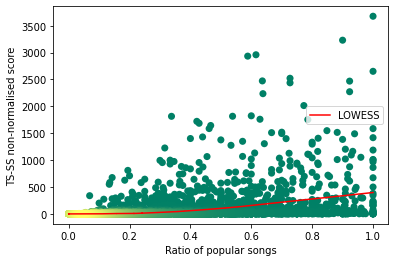

In [ ]:
plot(TS_SS_nonorm2, np.divide(pop_score2, distinct_songs2.astype("float")), "Ratio of popular songs", "TS-SS non-normalised score", "TS-SS-R_pop", frac = 0.3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


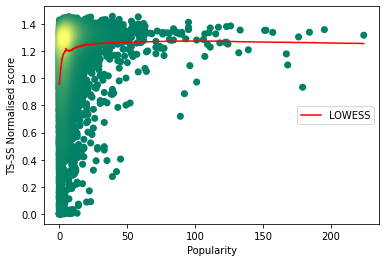

In [ ]:
plot(TS_SS_norm2*10000, pop_score2, "Popularity", "TS-SS Normalised score", "TS-SS-N_pop", frac = 0.3)

In [ ]:
np.where(TS_SS<0.0000000001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(array([ 163,  212,  868, 1200, 2732, 3220, 6290, 6763, 7084, 7249, 7323,
        7458, 7662, 9279]),)

In [ ]:
np.where(np.array(GS)>0.9999999)

(array([8972]),)

In [ ]:
GS[9279]

0.9946418842185596

In [ ]:
toy_triplets[toy_triplets["UserId"]==users[7662]]

UserId  ...                 Song
358409  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...          Star Breath
358410  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...  I Finally Found You
358411  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...  Historia De Un Amor
358412  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...          Piel Canela
358413  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...         Bésame Mucho
358414  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...             Perfidia
358415  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...             Como Fué
358416  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...               Dimelo
358417  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...            La Puerta
358418  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...                 Amor
358419  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...           La Mentira
358420  504b0b4bac52787dc0e86c046ecdb220df7eb3cc  ...       Noche De Ronda

[12 rows x 6 columns]

In [ ]:
TS_SS[8972]

nan

In [ ]:
pd.DataFrame(TS_SS).describe()

0
count  9.997000e+03
mean   2.780081e+01
std    1.550038e+02
min    1.760873e-15
25%    2.266076e-04
50%    1.234074e-02
75%    1.059745e+00
max    3.675942e+03

# Concordance


In [ ]:
GS2 = np.delete(GS, index)

In [ ]:
pd.DataFrame(GS2).describe()

0
count  9997.000000
mean      0.491930
std       0.152599
min       0.187207
25%       0.381408
50%       0.462401
75%       0.573363
max       0.999996

In [ ]:
np.where(GS2<0.2)

(array([5928, 7477, 8599]),)

In [ ]:
toy_triplets[toy_triplets["UserId"]]

In [ ]:
import scipy.stats as stats

print(stats.kendalltau(GS2, TS_SS_nonorm2),
      stats.kendalltau(GS2, TS_SS_norm2),
      stats.kendalltau(TS_SS_norm2, TS_SS_nonorm2))

NameError: ignored

In [ ]:
GS_r = len(GS2) - stats.rankdata(GS2)
TS_SS_nonorm_r = stats.rankdata(TS_SS_nonorm2)
TS_SS_norm_r = stats.rankdata(TS_SS_norm2)

In [ ]:
diff_a = GS_r - TS_SS_nonorm_r
diff_b = GS_r - TS_SS_norm_r
diff_c = TS_SS_norm_r - TS_SS_nonorm_r

In [ ]:
diffs = np.vstack((diff_a, diff_b))
diffs = np.vstack((diffs, diff_c))

In [ ]:
TSSS_r

array([ 463., 6272.,  498., ..., 5141., 3263., 9366.])

In [ ]:
TS_SS2

array([1.05769083e-06, 1.03806183e-01, 1.23882965e-06, ...,
       1.52548626e-02, 7.87553606e-04, 6.54462861e+01])

In [ ]:
diff = GS_r-TSSS_r

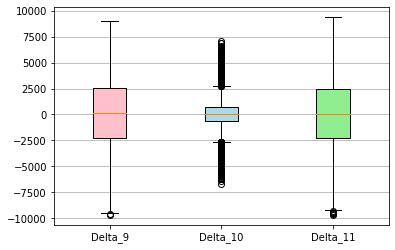

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
labels = ["Delta_9", "Delta_10", "Delta_11"]

bplot = axes.boxplot(np.transpose(diffs),
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
# lots of negative values meaning shannon<relative. 

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']

for patch, color in zip(bplot['boxes'], colors):
      patch.set_facecolor(color)

# adding horizontal grid lines

axes.yaxis.grid(True)

plt.savefig("box_plots_3", format = "png", transparent = True, dpi=500)
plt.show()

In [ ]:
pd.DataFrame(diff_a).describe()

0
count  9997.000000
mean     -1.000000
std    3533.787142
min   -9680.000000
25%   -2310.000000
50%     103.000000
75%    2547.000000
max    9007.000000

In [ ]:
loc = np.where(diff_a==9007)
print(loc)

(array([8242]),)


In [ ]:
print(GS_r[loc], TS_SS_nonorm_r[loc], GS2[loc], TS_SS_nonorm2[loc])

[9478.] [471.] [0.29393903] [1.09399989e-06]


In [ ]:
print(total_playcount2[loc], distinct_song2[loc], distinct_artists2[loc], pop_score2[loc])

[20.] [76] [19] [0]


In [ ]:
print(TS_SS_norm_r[loc])

[6637.]


In [ ]:
pd.set_option("display.max_rows", None)
toy_triplets[toy_triplets["UserId"]==users2[8242]][["Count", "Artist", "Song"]].to_latex()

"\\begin{tabular}{llll}\n\\toprule\n{} & Count &                            Artist &                                            Song \\\\\n\\midrule\n387689 &     1 &                        Kim Carnes &                                Bette Davis Eyes \\\\\n387690 &     1 &                          Westlife &                                 You Raise Me Up \\\\\n387691 &     1 &                 The Grateful Dead &                        Peggy-O [Studio Outtake] \\\\\n387692 &     1 &                      Bishop Allen &                                      Shanghaied \\\\\n387693 &     1 &                     Kylie Minogue &                                       This Girl \\\\\n387694 &     1 &                       Harold Budd &                                    Gypsy Violin \\\\\n387695 &     1 &                   The Hold Steady &                                     Chips Ahoy! \\\\\n387696 &     1 &           Lords Of The New Church &                                Dreams \\& Desire

In [ ]:
pd.DataFrame(diff_b).describe()

0
count  9997.00000
mean     -1.00000
std    1458.50522
min   -6685.00000
25%    -629.00000
50%      58.00000
75%     732.00000
max    7064.00000

In [ ]:
loc = np.where(diff_b==7064)
print(loc)

NameError: ignored

In [ ]:
loc = 8599

In [ ]:
print(GS_r[loc], TS_SS_norm_r[loc], GS2[loc], TS_SS_norm2[loc])

[9996.] [2932.] [0.18720687] [0.00011217]


In [ ]:
print(total_playcount2[loc], distinct_songs2[loc], distinct_artists2[loc], pop_score2[loc])

864.0 481 226 45


In [ ]:
pd.set_option("display.max_rows", None)
toy_triplets[toy_triplets["UserId"] == users2[8599]].groupby(["Artist"]).sum()[["Count"]].to_latex()

"\\begin{tabular}{lr}\n\\toprule\n{} &  Count \\\\\nArtist                                             &        \\\\\n\\midrule\n10 Years                                           &      2 \\\\\n4hero                                              &      1 \\\\\nA Perfect Circle                                   &      9 \\\\\nA.C.T                                              &      1 \\\\\nAir                                                &      1 \\\\\nAlan Silvestri                                     &      1 \\\\\nAlceu Valença                                      &      5 \\\\\nAlex Lloyd                                         &      1 \\\\\nAlfredo Kraus                                      &      3 \\\\\nAlter Bridge                                       &      1 \\\\\nAmerican Hi-Fi                                     &     15 \\\\\nAmerican Music Club                                &      1 \\\\\nAmos Lee                                           &      5 \\\\\nAmy Winehouse

In [ ]:
pd.set_option("display.max_rows", None)
toy_triplets[toy_triplets["UserId"]==users2[8599]]

UserId  ...                                               Song
405645  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                           Stronger
405646  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                     Constellations
405647  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                      Sehr kosmisch
405648  e0f9668e65a028b27a5645984710f960d01cb41f  ...  I'll Be Missing You (Featuring Faith Evans & 1...
405649  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                         The Middle
405650  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        Are You In?
405651  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                              Belle
405652  e0f9668e65a028b27a5645984710f960d01cb41f  ...                              Don't Dream It's Over
405653  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                         16 Candles
405654  e0f9668e65a028b27a5645984710f960d01cb41f  ...                     Dog Days Are Over (Radio Edit)
405655  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        Bulletproof
405656  e0f9668e65a028b27a5645984710f960d01cb41f  ...                              Sinisten tähtien alla
405657  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        Technologic
405658  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                               DVNO
405659  e0f9668e65a028b27a5645984710f960d01cb41f  ...                        The Funeral (Album Version)
405660  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                  Hey There Delilah
405661  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                   3AM (LP Version)
405662  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        The Maestro
405663  e0f9668e65a028b27a5645984710f960d01cb41f  ...    Deep Inside Of You (2006 Remastered LP Version)
405664  e0f9668e65a028b27a5645984710f960d01cb41f  ...                              Moar Ghosts 'n' Stuff
405665  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        Work On You
405666  e0f9668e65a028b27a5645984710f960d01cb41f  ...       You Don't Know Me (featuring Regina Spektor)
405667  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                   Times Like These
405668  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                    Do You Remember
405669  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                                Ort
405670  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                           Rooftops
405671  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                              Flake
405672  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        Not In Love
405673  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                 Decades Of Despair
405674  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                 Wish You Were Here
405675  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                         Just Dance
405676  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                              Black
405677  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                All The Right Moves
405678  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                         My Name Is
405679  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                      I'm On A Boat
405680  e0f9668e65a028b27a5645984710f960d01cb41f  ...                                        Bubble Toes
405681  e0f9668e65a028b27a5645984710f960d01cb41f  ...  All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop...
405682  e0f9668e65a028b27a5645984710f960d01cb41f  ..

# New Section

In [ ]:
pd.DataFrame(diff_c).describe()

0
count  9997.000000
mean      0.000000
std    3562.227081
min   -9693.000000
25%   -2259.000000
50%      80.000000
75%    2452.000000
max    9359.000000

In [ ]:
loc = np.argwhere(diff_c ==-9693)
print(loc )

[[9413]]


In [ ]:
print(TS_SS_nonorm_r[loc], TS_SS_norm_r[loc], TS_SS_nonorm2[loc], TS_SS_norm2[loc])

[[9976.]] [[283.]] [[1586.11615354]] [[4.17933876e-05]]


In [ ]:
print(total_playcount2[loc], distinct_songs2[loc], distinct_artists2[loc], pop_score2[loc])

[[18.]] [[13]] [[12]] [[13]]


In [ ]:
pd.set_option("display.max_rows", None)
toy_triplets[toy_triplets["UserId"]==users2[9413]][["Count", "Artist", "Song"]].to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} & Count &                     Artist &                                  Song \\\\\n\\midrule\n444702 &     1 &                   Harmonia &                         Sehr kosmisch \\\\\n444703 &     1 &              Justin Bieber &                      Somebody To Love \\\\\n444704 &     1 &                      Björk &                                  Undo \\\\\n444705 &     1 &     Florence + The Machine &        Dog Days Are Over (Radio Edit) \\\\\n444706 &     2 &                      Train &                      Hey\\_ Soul Sister \\\\\n444707 &     3 &         Charttraxx Karaoke &                             Fireflies \\\\\n444708 &     3 &                OneRepublic &                               Secrets \\\\\n444709 &     1 &              Kings Of Leon &                               Revelry \\\\\n444710 &     1 &  Usher featuring will.i.am &                                   OMG \\\\\n444711 &     1 &         Lil Wayne / Eminem &          

In [ ]:
users[2]

'21c310f8a98769736f6e82d6f2cd6fd83d88391d'

In [ ]:
users[9416]

'4aadb05741c55b9546af33110dd1a08d1d90cd6a'

In [ ]:
users2[9413]

'4aadb05741c55b9546af33110dd1a08d1d90cd6a'

# Custom


In [ ]:
artists = np.unique(toy_triplets["Artist"])

In [ ]:
pd.set_option("display.max_rows", None)
pd.DataFrame(artists)

0
0                                                    !!!
1                                           & And Oceans
2                                           '68 Comeback
3                                   'N Sync/Phil Collins
4                                           'Til Tuesday
5                           't Hof Van Commerce & Brahim
6                                          (Love) Tattoo
7                                             (hed) p.e.
8                                 *NSYNC featuring Nelly
9                                                 *Shels
10                                    + / - {Plus/Minus}
11                                                  + 44
12                                                   +44
13                                            -123 minut
14                                              -123min.
15                                                   -M-
16          ...And You Will Know Us By The Trail Of Dead
17                                                   091
18                                             1 40 4 20
19                                          1 Giant Leap
20                         1 Giant Leap feat. Baaba Maal
21     1 Giant Leap feat. Eddi Reader_ The Mahotella ...
22     1 Giant Leap feat. Grant Lee Phillips & Horace...
23                     1 Giant Leap feat. Michael Franti
24        1 Giant Leap feat. Michael Stipe & Asha Bhosle
25         1 Giant Leap feat. Robbie Wlliams & Maxi Jazz
26       1 Giant Leap feat. The Mahotella Queens & Ulali
27                                          1 Mile North
28                                          1-Speed Bike
29                                              10 Years
30                                             1000names
31                                                  1001
32                                                   101
33                                           101 Strings
34                                 101 Strings Orchestra
35                                        10_000 Maniacs
36                                                  10cc
37                                                   112
38                               112 / Ludacris / Chingy
39                                        12 Step Rebels
40                                             12 Stones
41                                       1200 Micrograms
42                                             1200 Mics
43                                            13th Chime
44                                             16 Frames
45                                         16 Horsepower
46                                                16Volt
47                                            17 Hippies
48                                            1900s_ The
49                                 1910 Fruitgum Company
50                                                  1919
51                                                 1990s
52                                                  1997
53                                       1_000 Homo DJ's
54                                              2 Belgen
55                                             2 Bit Pie
56                           2 Brothers On The 4th Floor
57                                             2 Eivissa
58                                             2 Fabiola
59                                           2 In A Room
60                                           2 LIVE CREW
61                                             2 Minutos
62                   2 Pistols / Slick Pulla / Blood Raw
63                         2 Pistols / T-Pain / Tay Dizm
64                                         2 Skinnee J's
65                                           2 Unlimited
66                                               2 Vibez
67                                           2-4 Grooves
68                                2-Pac ft. DMX & Xzibit
69                                   2-Pac ft. Nate Dogg
70      

In [ ]:
pd.set_option("display.max_rows", None)
toy_triplets[["Song", "SongId"]][toy_triplets["Artist"]=="Lady GaGa"]

Song              SongId
167                    Monster  SOEYVHS12AB0181D31
708                  Alejandro  SOSCIZP12AB0181D2F
839                  Alejandro  SOSCIZP12AB0181D2F
1064    Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
1179             Paper Gangsta  SODXRTY12AB0180F3B
1181                Speechless  SOXGQEM12AB0181D35
1186                   Monster  SOEYVHS12AB0181D31
1190            Boys Boys Boys  SOSHVEI12AF729AF6B
1195                   Fashion  SOVJYNA12AB01806DD
1565               Again Again  SOMONAP12AB0181D21
1566    Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
1567              Disco Heaven  SOJVYJH12AB0180F4F
1682                 Alejandro  SOSCIZP12AB0181D2F
1878                 Alejandro  SOSCIZP12AB0181D2F
1908                Speechless  SOXGQEM12AB0181D35
3679                 Alejandro  SOSCIZP12AB0181D2F
4192                 Alejandro  SOSCIZP12AB0181D2F
5324             Paper Gangsta  SODXRTY12AB0180F3B
5330                Speechless  SOXGQEM12AB0181D35
5369                 Alejandro  SOSCIZP12AB0181D2F
5373                   Monster  SOEYVHS12AB0181D31
5394               Again Again  SOMONAP12AB0181D21
5395    Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
5396                     Teeth  SOCBQKE12AB018548E
5397              Disco Heaven  SOJVYJH12AB0180F4F
5398            Boys Boys Boys  SOSHVEI12AF729AF6B
5791                 Alejandro  SOSCIZP12AB0181D2F
6094                 Alejandro  SOSCIZP12AB0181D2F
6837                 Alejandro  SOSCIZP12AB0181D2F
7161                 Alejandro  SOSCIZP12AB0181D2F
7244               Again Again  SOMONAP12AB0181D21
7245    Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
7246              Disco Heaven  SOJVYJH12AB0180F4F
7998             Paper Gangsta  SODXRTY12AB0180F3B
8000                Speechless  SOXGQEM12AB0181D35
8062                 Alejandro  SOSCIZP12AB0181D2F
8081                   Monster  SOEYVHS12AB0181D31
8110    Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
8111                     Teeth  SOCBQKE12AB018548E
8113              Disco Heaven  SOJVYJH12AB0180F4F
8230                  LoveGame  SOZVSSP12AB01819DE
8347             Paper Gangsta  SODXRTY12AB0180F3B
8772                 Alejandro  SOSCIZP12AB0181D2F
8796             Paper Gangsta  SODXRTY12AB0180F3B
8858                 Alejandro  SOSCIZP12AB0181D2F
9706               Again Again  SOMONAP12AB0181D21
9766                  LoveGame  SOZVSSP12AB01819DE
10713                Alejandro  SOSCIZP12AB0181D2F
10895           Boys Boys Boys  SOSHVEI12AF729AF6B
11717            Paper Gangsta  SODXRTY12AB0180F3B
11725                Alejandro  SOSCIZP12AB0181D2F
13567                  Monster  SOEYVHS12AB0181D31
14313                Alejandro  SOSCIZP12AB0181D2F
14586                Alejandro  SOSCIZP12AB0181D2F
16676                Alejandro  SOSCIZP12AB0181D2F
18184                Alejandro  SOSCIZP12AB0181D2F
19197                  Monster  SOEYVHS12AB0181D31
19201   Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
19202           Boys Boys Boys  SOSHVEI12AF729AF6B
19367                Alejandro  SOSCIZP12AB0181D2F
19676            Paper Gangsta  SODXRTY12AB0180F3B
19678               Speechless  SOXGQEM12AB0181D35
19681                  Monster  SOEYVHS12AB0181D31
19685                    Teeth  SOCBQKE12AB018548E
19686             Disco Heaven  SOJVYJH12AB0180F4F
19687           Boys Boys Boys  SOSHVEI12AF729AF6B
19726            Paper Gangsta  SODXRTY12AB0180F3B
19727               Speechless  SOXGQEM12AB0181D35
19731                  Monster  SOEYVHS12AB0181D31
19734              Again Again  SOMONAP12AB0181D21
19735   Beautiful_ Dirty_ Rich  SOASXQD12AB018902F
19736                    Teeth  SOCBQKE12AB018548E
19737             Disco Heaven  SOJVYJH12AB0180F4F
19738           Boys Boys Boys  SOSHVEI12AF729AF6B
20910               Speechless  SOXGQEM12AB0181D35
20940                 LoveGame  SOZVSSP12AB01819DE
22402                Alejandro  SOSCIZP12AB0181D2F
24346                Alejandro  SOSCIZP12AB0181D

In [ ]:
song_ids = ["SOJVYJH12AB0180F4F", "SOIYPLX12AB0189CA2", "SOJEJNM12A58A7C393",
            "SOZEKHN12AB018D56E", "SOSCIZP12AB0181D2F", "SOSHVEI12AF729AF6B"]
embeds["beta"][embeds["mapping"]==song_ids]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


array([], shape=(0, 384546, 100), dtype=float32)

In [ ]:
song_ids = ["SOHGPYP12AB017E134", "SOWKKEF12A8C13B4D6", "SOBTEDP12A6D4F970F",
"SOKOXWU12AF72AD1BC", "SOYFGYE12A670215BE"]

embeds["beta"][embeds["mapping"]==song_ids]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


array([], shape=(0, 384546, 100), dtype=float32)

In [ ]:
subset = np.zeros((5, 100))
for i, id in enumerate(song_ids):
  subset[i,:] = embeds["beta"][embeds["mapping"]==id]

In [ ]:
subset_norm = preprocessing.normalize(subset, norm='l2')

In [ ]:
weight = np.array([1,1,1,1,1]).reshape(-1,1)
subset_centre = centroid(subset_norm, weight)

In [ ]:
GS_SUB = np.linalg.norm(subset_centre)
GS_SUB

0.5626784667810723

In [ ]:

a = []
for j, w in zip(subset_norm, weight):
    #call a class
  tsss = TS_SS()
  a.append(w *tsss(j,subset_centre))
joint = np.sum(a)/np.sum(weight)

In [ ]:
joint*10000

0.9474504040899172

In [ ]:
TS_SS_norm_plus = stats.rankdata(np.hstack((TS_SS_norm2, joint)))

NameError: ignored

In [ ]:
TS_SS_norm_plus[9997]

2300.0

In [ ]:
GS_plus = len(GS_plus) - stats.rankdata(np.hstack((GS2, GS_SUB)))

In [ ]:
GS_plus[9997]

3314.0

# Cosine between each song

In [ ]:
songs = toy_triplets["SongId"].unique().tolist()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

b = []
for j in tqdm(songs):
  # merging with the location as found in the embeds["mapping"]
  loc_temp = embeds_songs["Location"][embeds_songs["SongId"]==j]
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp].to_numpy()

  a = []
  for i in pan_emb.to_numpy():
    c = extract_vec.reshape(-1,1)
    d = i.reshape(-1,1)
    a.append(cosine_similarity(c, d))
  b.append(np.sum(np.array(a)==1))  



KeyboardInterrupt: ignored

In [ ]:
b = [1,2,2,3]
b

[1, 2, 2, 3]

In [ ]:
len(pan_emb.to_numpy()[1])

100